In [1]:
import urllib.request
import zipfile
import pandas
import numpy
import re
import nltk
from sklearn.metrics import f1_score

from langdetect import detect
from googletrans import Translator

In [2]:
# #Fetching dataset
# url = "https://github.com/signerebassoo/COMP3222/blob/master/assignment-comp3222-comp6246-mediaeval2015-dataset.zip?raw=true"
# filename = "mediaeval.zip"
# urllib.request.urlretrieve(url, filename)

# #Extracting zip
# zfile = zipfile.ZipFile("mediaeval.zip", "r")
# zfile.extractall()
# zfile.close()

In [3]:
trainData = pandas.read_csv("mediaeval-2015-trainingset.txt", sep="	")
testData = pandas.read_csv("mediaeval-2015-testset.txt", sep="	")

#Creating DataFrames for training and testing
df_train = pandas.DataFrame(data = trainData)
df_test = pandas.DataFrame(data = testData)

# Data Characterization

In [4]:
trainData.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake


In [5]:
trainData.info() #Metadata of training data, including size

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14277 non-null  int64 
 1   tweetText   14277 non-null  object
 2   userId      14277 non-null  int64 
 3   imageId(s)  14277 non-null  object
 4   username    14277 non-null  object
 5   timestamp   14277 non-null  object
 6   label       14277 non-null  object
dtypes: int64(2), object(5)
memory usage: 780.9+ KB


In [6]:
testData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     3755 non-null   int64 
 1   tweetText   3755 non-null   object
 2   userId      3755 non-null   int64 
 3   imageId(s)  3755 non-null   object
 4   username    3755 non-null   object
 5   timestamp   3755 non-null   object
 6   label       3755 non-null   object
dtypes: int64(2), object(5)
memory usage: 205.5+ KB


In [7]:
df_train.shape

(14277, 7)

In [8]:
df_test.shape #Size of testing data

(3755, 7)

In [9]:
#Determine events covered and their frequency by image names in training data
df_train.rename(columns = {'imageId(s)':'imgs'}, inplace = True)
imgCount = df_train.groupby(df_train.imgs.str.split('_').str[0])['tweetId'].nunique()
print (imgCount)

imgs
boston                 546
bringback              131
columbianChemicals     185
elephant                13
livr                     9
malaysia               501
passport                46
pigFish                 14
sandyA                9695
sandyB                2621
sochi                  402
underwater             112
Name: tweetId, dtype: int64


In [10]:
#Determine events covered and their frequency by image names in testing data
df_test.rename(columns = {'imageId(s)':'imgs'}, inplace = True)
imgCount = df_test.groupby(df_test.imgs.str.split('_').str[0])['tweetId'].nunique()
print (imgCount)

imgs
eclipse        277
garissa         77
nepal         1353
samurai        218
syrianboy     1769
varoufakis      61
Name: tweetId, dtype: int64


In [11]:
#Helper to look into the tweetText of a particular event image to determine what the event is
selector = []
for imgs in df_train['imgs']:
    if "sandy" in imgs:
        selector.append(True)
    else:
        selector.append(False)
        
isEvent = pandas.Series(selector)

df_event = df_train[isEvent].head(61)

for tweet in df_event['tweetText']:
    print(tweet)

¿Se acuerdan de la película: “El día después de mañana”? Me recuerda a lo que está pasando con el huracán #Sandy. http://t.co/JQQeRPwN
@milenagimon: Miren a Sandy en NY!  Tremenda imagen del huracán. Parece el "Día de la Independencia 2" http://t.co/41jUweux REAL! RT.
Buena la foto del Huracán Sandy, me recuerda a la película Día de la Independencia #ID4 #Sandy  http://t.co/PTdAXABZ
Scary shit #hurricane #NY http://t.co/e4JLBUfH
My fave place in the world #nyc #hurricane #sandy #statueofliberty 🗽 http://t.co/Ex61doZk
42nd #time #square #NYC #subway #hurricane http://t.co/daX5YY7X
Just in time for #halloween a photo of #hurricane #sandy #frankenstorm http://t.co/xquKB4VN
Crazy pic of #Hurricane #Sandy prayers go out to family and friends on the East Coast http://t.co/c4sceiMt
#sandy #newyork #hurricane #statueofliberty #USA http://t.co/iQfEbO1E
#nyc #hurricane http://t.co/Gv3QxZlq
robertosalibaba  god be with u brother #sandy #hurricane #newyork http://t.co/GXheTqlO
#Crazy #Hurricane #S

In [12]:
langs = dict()

for tweet in df_train['tweetText']:
    try:
        lan = detect(tweet)
    except:
        pass
        lan = "Unknown"
        print(tweet)
    if lan in langs.keys():
        langs[lan] = langs[lan] + 1
    else:
        langs[lan] = 1

Man sandy Foreal??  ⚡⚡⚡☔☔⚡🌊🌊☁🚣⛵💡🔌🚬🚬🚬🔫🔫🔒🔒🔐🔑🔒🚪🚪🚪🔨🔨🔨🏊🏊🏊🏊🎣🎣🎣😱😰😖😫😩😤💨💨💨💨💦💦💦💧💦💥💥💥👽💩🙌🙌🙌🙌🙌🏃🏃🏃🏃🏃👫👭💏👪👪👬👭💑🙇🌕🌕🌕🌎 http://t.co/vEWVXy10


💧🙌🌕🌎🙌🙌🏃??  ⚡⚡☔⚡🌊⚡☔🌊🚬🔑🔒🚪🚬🔫🔫🔒☁🚣⛵💡🔌🚬🔒🔐🎣🎣😱🔨😖🚪🚪😫💦😩😤🔨💦🎣💦🔨🏊🏊💨🏊💨💨💥💥💦💥👽💩👪👬🏃🏃🏃🏃👫👭💑🙌💨🏊🙌👭💏👪🙇🌕🌕😰 

In [13]:
print (langs)

{'es': 1292, 'en': 10955, 'da': 29, 'sq': 9, 'bg': 9, 'it': 104, 'no': 40, 'fr': 214, 'nl': 89, 'pt': 160, 'de': 122, 'tl': 307, 'sv': 47, 'cy': 125, 'id': 180, 'ru': 60, 'ja': 21, 'ar': 79, 'vi': 13, 'ca': 35, 'hu': 5, 'so': 122, 'fi': 11, 'pl': 40, 'lt': 7, 'sk': 14, 'af': 69, 'el': 5, 'he': 1, 'hr': 4, 'tr': 30, 'zh-cn': 9, 'ro': 5, 'fa': 4, 'sl': 6, 'et': 10, 'sw': 14, 'ko': 6, 'th': 19, 'cs': 2, 'Unknown': 1, 'mk': 1, 'hi': 1, 'lv': 1}


# Data Preprocessing

In [14]:
#Changing 'humor' to 'fake'
df_train.loc[(df_train.label == 'humor'),'label'] = 'fake'
df_test.loc[(df_test.label == 'humor'),'label'] = 'fake'

In [15]:
#Removing retweets, reposts, and modified tweets
rtPattern1 = "(RT|rt|MT|mt|RP|rp):? @\w*:?"
rtPattern2 = "(\bRT\b|\brt\b|\bMT\b|\bmt\b|\bRP\b|\brp\b)"
rtPattern3 = "(@\w*:)"
rtPattern4 = "(#rt|#RT|#mt|#MT|#rp|#retweet|#Retweet|#modifiedtweet|#modifiedTweet|#ModifiedTweet|#repost|#Repost)"
rtPattern5 = "(via @\w*)"

retweets = df_train['tweetText'].str.contains(rtPattern1)
df_train = df_train[~retweets]

retweets = df_train['tweetText'].str.contains(rtPattern2)
df_train = df_train[~retweets]

retweets = df_train['tweetText'].str.contains(rtPattern3)
df_train = df_train[~retweets]

retweets = df_train['tweetText'].str.contains(rtPattern4)
df_train = df_train[~retweets]

retweets = df_train['tweetText'].str.contains(rtPattern5)
df_train = df_train[~retweets]

df_train.reset_index(drop=True, inplace=True)
df_train.shape

D:\Anaconda\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


(11550, 7)

In [16]:
#Removing remaining twitter handles @username
df_train['tweetText'] = df_train['tweetText'].apply(lambda text: re.sub(r'@\w*', "", text))

In [17]:
#Removing emojis
emojis = re.compile("["
                    u"\U0001F600-\U0001F64F"
                    u"\U0001F300-\U0001F5FF"
                    u"\U0001F680-\U0001F6FF"
                    u"\U0001F1E0-\U0001F1FF"
                    u"\U00002702-\U000027B0"
                    u"\U000024C2-\U0001F251"
                    "]+", flags=re.UNICODE)

df_train['tweetText'] = df_train['tweetText'].apply(lambda text: emojis.sub(r'', text) if emojis.search(text) else text)

In [18]:
#Cleaning symbols - ampersand and newline
df_train['tweetText'] = df_train['tweetText'].apply(lambda text: re.sub(r'&amp;|\\n', '', text))

In [19]:
#Removing urls
df_train['tweetText'] = df_train['tweetText'].apply(lambda text: re.sub(r'http\S+', '', text))
df_train['tweetText'] = df_train['tweetText'].apply(lambda text: re.sub(r'\\\/\S+', '', text))

In [20]:
#NOT USED
#Translating to English

# i = 0
# for tweet in df_train['tweetText']:
#     try:
#         lan = detect(tweet)
#     except:
#         continue
#     if lan != 'en':
#         tr = Translator()
#         trText = tr.translate(tweet).text
#         print(trText)
#         #TODO replace cell value to translation
#     i = i + 1

In [21]:
#Removing whitespace
df_train['tweetText'] = df_train['tweetText'].apply(lambda text: " ".join(text.split()))

In [22]:
#Initialise stopwords
stopwords = nltk.corpus.stopwords.words()
stopwords.extend([':', ';', '[', ']', '"', "'", '(', ')', '.', '?', '#', '@', '...'])

In [23]:
#Removing stopwords
df_train['filteredTweet'] = df_train['tweetText'].apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))

In [24]:
#Lemmatising
tokeniser = nltk.tokenize.WhitespaceTokenizer()
lemmatiser = nltk.stem.WordNetLemmatizer()

df_train['lemmatisedTweet'] = df_train['filteredTweet'].apply(lambda x: ' '.join([lemmatiser.lemmatize(w) for w in tokeniser.tokenize(x)]))
df_train.head(10)

,tweetId,tweetText,userId,imgs,username,timestamp,label,filteredTweet,lemmatisedTweet
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake,¿Se acuerdan película: “El día después mañana”...,¿Se acuerdan película: “El día después mañana”...
1,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake,"Buena foto Huracán Sandy, recuerda película Dí...","Buena foto Huracán Sandy, recuerda película Dí..."
2,262996108400271360,Scary shit #hurricane #NY,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake,Scary shit #hurricane #NY,Scary shit #hurricane #NY
3,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake,My fave place world #nyc #hurricane #sandy #st...,My fave place world #nyc #hurricane #sandy #st...
4,263364439582060545,42nd #time #square #NYC #subway #hurricane,163674788,sandyA_fake_23,classycg,Tue Oct 30 19:39:10 +0000 2012,fake,42nd #time #square #NYC #subway #hurricane,42nd #time #square #NYC #subway #hurricane
5,262927032705490944,Just in time for #halloween a photo of #hurric...,246153081,sandyA_fake_14,j_unit87,Mon Oct 29 14:41:04 +0000 2012,fake,Just time #halloween photo #hurricane #sandy #...,Just time #halloween photo #hurricane #sandy #...
6,263321078884077568,Crazy pic of #Hurricane #Sandy prayers go out ...,199565482,sandyA_fake_29,MrBlakMagik,Tue Oct 30 16:46:52 +0000 2012,fake,Crazy #Hurricane #Sandy prayers go family frie...,Crazy #Hurricane #Sandy prayer go family frien...
7,263111677485142017,#sandy #newyork #hurricane #statueofliberty #USA,78475739,sandyA_fake_15,safi37,Tue Oct 30 02:54:46 +0000 2012,fake,#sandy #newyork #hurricane #statueofliberty #USA,#sandy #newyork #hurricane #statueofliberty #USA
8,262977091983785985,#nyc #hurricane,869777653,sandyA_fake_29,kingmichael03,Mon Oct 29 17:59:59 +0000 2012,fake,#nyc #hurricane,#nyc #hurricane
9,262989009930833920,robertosalibaba god be with u brother #sandy #...,359592461,sandyA_fake_08,Michael_Saliba,Mon Oct 29 18:47:20 +0000 2012,fake,robertosalibaba god brother #sandy #hurricane ...,robertosalibaba god brother #sandy #hurricane ...


# Algorithm Design and Training

In [25]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
import numpy as np

D:\Anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [26]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, misclass))
    plt.show()

In [27]:
Train_real_size = df_train[df_train.label=='real'].groupby(['label']) .size()
Train_real_size

label
real    3651
dtype: int64

In [28]:
Train_fake_size = df_train[df_train.label=='fake'].groupby(['label']) .size()
Train_fake_size

label
fake    7899
dtype: int64

In [29]:
train_fake = df_train[df_train['label']=='fake'].sample(n=len(df_train[df_train['label']=='real']) , random_state=1234)
train_real = df_train[df_train['label']=='real']
train_total = pandas.concat([train_real, train_fake], ignore_index=True)
train_total = train_total.sample(frac = 1)
train_total

,tweetId,tweetText,userId,imgs,username,timestamp,label,filteredTweet,lemmatisedTweet
3149,263108287241781248,Foto de tarms15 #hurricanesandy #blackout #NYC,89221442,sandyB_real_60,IzisFilipaldi,Tue Oct 30 02:41:18 +0000 2012,real,Foto tarms15 #hurricanesandy #blackout #NYC,Foto tarms15 #hurricanesandy #blackout #NYC
217,263069509181652995,Woaw Sandy is knocking down buildings in Chelsea,45081270,sandyA_real_09,styledevon,Tue Oct 30 00:07:13 +0000 2012,real,Woaw Sandy knocking buildings Chelsea,Woaw Sandy knocking building Chelsea
5748,264635320946024448,Has Sandy gone yet???,45793095,sandyA_fake_41,georginah23,Sat Nov 03 07:49:11 +0000 2012,fake,Has Sandy gone yet???,Has Sandy gone yet???
7297,264468524519526400,LMFAO!!! #Sandy,316093452,sandyA_fake_40,_IsOnMyMind,Fri Nov 02 20:46:24 +0000 2012,fake,LMFAO!!! #Sandy,LMFAO!!! #Sandy
5703,263818159662960640,The Tomb of the Unknown Soldier after the hurr...,495008057,sandyA_fake_03,Cardinals_ST,Thu Nov 01 01:42:05 +0000 2012,fake,The Tomb Unknown Soldier hurricane evacuation....,The Tomb Unknown Soldier hurricane evacuation....
...,...,...,...,...,...,...,...,...,...
4322,262976593327169536,Sandy charges New York - be safe #NYC #sandy,35555545,sandyA_fake_29,faysalzok,Mon Oct 29 17:58:00 +0000 2012,fake,Sandy charges New York - safe #NYC #sandy,Sandy charge New York - safe #NYC #sandy
3672,446424632074465281,"Imagen de avión no identificado en Tailandia, ...",54259597,malaysia_fake_15,ObservadorUY,Wed Mar 19 23:15:01 +0000 2014,fake,"Imagen avión identificado Tailandia, podría se...","Imagen avión identificado Tailandia, podría se..."
5841,430419958833479680,This photo shows Russia may have a toilet prob...,2168324624,sochi_fake_16,TheGlasgowCurse,Mon Feb 03 19:18:09 +0000 2014,fake,This photo shows Russia may toilet problem Soc...,This photo show Russia may toilet problem Soch...
4920,325233605964070913,Reddit and 4chan's efforts to identify the Bos...,17153944,"boston_fake_03,boston_fake_35",fraserferguson,Fri Apr 19 13:05:08 +0000 2013,fake,Reddit 4chan's efforts identify Boston bombers...,Reddit 4chan's effort identify Boston bombers....


In [30]:
#Define features and target for training and testing
# tar_train = df_train.label
# ft_train = df_train.lemmatisedTweet
# tar_test = df_test.label
# ft_test = df_test.tweetText

tar_train = train_total.label
ft_train = train_total.lemmatisedTweet
tar_test = df_test.label
ft_test = df_test.tweetText

In [31]:
#Init Bag-of-Words
count_vectoriser = CountVectorizer(stop_words='english')
count_train = count_vectoriser.fit_transform(ft_train)
count_test = count_vectoriser.transform(ft_test)

In [32]:
#Init N-Gram
ngram_vectoriser = CountVectorizer(analyzer='char_wb', ngram_range=(2, 2))
ngram_train = ngram_vectoriser.fit_transform(ft_train)
ngram_test = ngram_vectoriser.transform(ft_test)

In [33]:
#Init TF-IDF
tfidf_vectoriser = TfidfVectorizer(stop_words='english', max_df=0.2)
tfidf_train = tfidf_vectoriser.fit_transform(ft_train)
tfidf_test = tfidf_vectoriser.transform(ft_test)

In [34]:
clf = MultinomialNB()

In [35]:
clf = BernoulliNB()

In [36]:
clf = PassiveAggressiveClassifier()

In [37]:
clf = SGDClassifier()

In [38]:
clf = SVC()

In [39]:
clf =  AdaBoostClassifier()

In [40]:
#clf =  QuadraticDiscriminantAnalysis()

In [41]:
#N-Grams
clf.fit(ngram_train, tar_train)

pred = clf.predict(ngram_test)
score = metrics.accuracy_score(tar_test, pred)

print("accuracy:   %0.3f" % score)

accuracy:   0.226


In [42]:
#Calculating F1 score
TP = 0 
FP = 0
TN = 0
FN = 0

for true, guess in zip(tar_test, pred):
    if(true == 'fake' and guess == 'fake'):
        TP = TP + 1
    if(true == 'real' and guess == 'fake'):
        FP = FP + 1
    if(true == 'real' and guess == 'real'):
        TN = TN + 1
    if(true == 'fake' and guess == 'real'):
        FN = FN + 1
        
precision = TP / (TP + FP)
recall = TP / (TP + FN)

f1 = 2 * ((precision * recall) / (precision + recall))
print("TP: %d FP: %d TN: %d FN: %d" % (TP, FP, TN, FN))
print("f1: %0.3f" % f1)

TP: 670 FP: 1032 TN: 177 FN: 1876
f1: 0.315


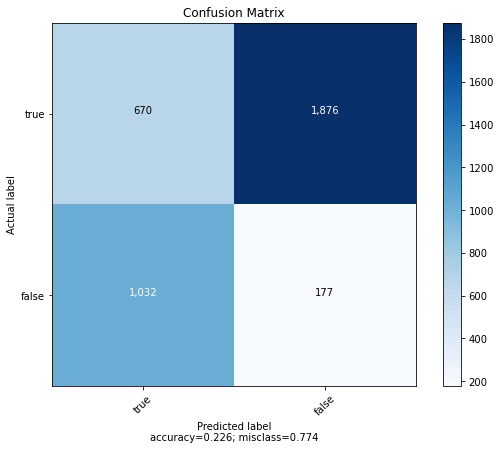

In [43]:
plot_confusion_matrix(cm      = np.array([[TP ,FN ],[ FP, TN ]]), 
                      normalize    = False,
                      target_names = ['true', 'false'],
                      title        = "Confusion Matrix")

#np.array([[TP,FN ],[ FP, TN]]), 

In [44]:
#Bag-of-Words
clf.fit(count_train, tar_train)

pred = clf.predict(count_test)
score = metrics.accuracy_score(tar_test, pred)

print("accuracy:   %0.3f" % score)

accuracy:   0.622


In [45]:
#TF-IDF
clf.fit(tfidf_train, tar_train)

pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(tar_test, pred)

print("accuracy:   %0.3f" % score)

accuracy:   0.674
